<a href="https://colab.research.google.com/github/rafaels100/TwittervsIMDb/blob/main/TwittervsIMDb_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP Final Laboratorio de Datos: Análisis de tweets sobre películas
El objetivo del presente trabajo es clasificar tweets sobre películas según opiniones positivas o negativas de las mismas.
Para ello entrenaremos un modelo de Multinomial Naive Bayes utilizando el dataset de películas y reviews disponible en el sitio IMDb, para que, dada una review que no vió, sea capaz de decir si dicha review es positiva o negativa.
Luego utilizaremos el modelo entrenado en IMDb para predecir si las "reviews" en los tweets que mencionan ciertas películas son positivas o negativas.
Como no tenemos "ratings" de los tweets sobre las películas, realizaremos un análisis de sentimiento de los tweets para validar el modelo, pues si el tweet es clasificado como opinión positiva, debería tener sentimientos positivos asociados a él, y viceversa si la opinion sobre la película fue negativa.

Otro de los objetivos del trabajo será entrenar un modelo de clasificación multiclase para poder predecir el puntaje de una review (de 1 a 5 estrellas).
Para ello sólo utilizaremos la base de datos de IMDb, pues ahora no sólo podremos entrenar al modelo con ella, sino validarlo viendo que las reviews que predice el modelo se condigan con las dadas por los usuarios en IMDb.

Descargamos e importamos las librerias necesarias:

In [ ]:
%%capture
!pip install pysentimiento
!pip install contractions
from google.colab import drive
drive.mount('/content/drive')
from pysentimiento import create_analyzer # Traemos el modulo de create_analyzer, fíjense que hay otras funcionalidades, como la de preprocesamiento
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
#para lidiar con las contracciones de texto
import contractions
#para lematizar
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
#hay que descargar estos modulos en particular, for reasons
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download('punkt')

#para hacer el modelo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
#para hacer Naive Bayes multinomial
from sklearn.naive_bayes import MultinomialNB
#Para hacer cross-validation y evaluar el modelo
from sklearn.model_selection import cross_val_score
#para auc score
from sklearn.metrics import roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 312 kB 4.2 MB/s 
     |████████████████████████████████| 175 kB 51.3 MB/s 
     |████████████████████████████████| 4.4 MB 53.4 MB/s 
     |████████████████████████████████| 212 kB 60.3 MB/s 
     |████████████████████████████████| 140 kB 53.9 MB/s 
     |████████████████████████████████| 1.1 MB 45.8 MB/s 
     |████████████████████████████████| 101 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 49.7 MB/s 
     |████████████████████████████████| 127 kB 50.3 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 271 kB 13.8 MB/s 
     |████████████████████████████████| 144 kB 48.6 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=4f8698ae88e5e684ddd01b1ecebaf654448d1840c52b6ede122b9a4c0379c146
  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#1ra Parte: Creación del dataset y exploración del mismo
La data fue obtenida al scrapear la pagina https://www.imdb.com/, de donde obtuvimos reviews de las 10 películas más populares del momento.
Para la siguiente etapa de la obtención de datos, recurrimos a la libreria academic research para descargar tweets referentes a cada una de las 10 películas, realizados en un lapso de dos semanas previas.

Cargamos la base de datos con las reviews, que se encuentran en archivos .csv, cada uno correspondiente a una de las 10 películas elegidas. Los nombres de los archivos tienen el id de la película, asignado a la misma por el sitio imdb.
A su vez, utilizamos el criterio: >5 opinion POSITIVA (representado por True), <= 5 opinion NEGATIVA (representado por False).

In [ ]:
#Para comparar con twitter uso el top de 10 pelis mas new y mas populares

dir = '/content/drive/MyDrive/laboDatos/'

#los ids de las 10 peliculas elegidas son:
idsPelis_top10 = [1745960, 9419884, 11138512, 4123432, 6710474, 1877830, 1464335, 7657566, 10872600, 11214590]
titulos_pelis = ['Top Gun: Maverick', 'Doctor Strange in the Multiverse of Madness', 'The Northman', 'Fantastic Beasts: The Secrets of Dumbledore', 'Everything Everywhere All at Once', 
                 'The Batman', 'Uncharted', 'Death on the Nile', 'Spider-Man: No Way Home', 'House of Gucci']

#itero por los ids y creo los dataframes para cada pelicula, leyendolo desde el archivo .csv correspondiente al id
#solo nos interesa quedarnos con las columnas de titulos y puntajes:
columnas = ["titulos", "puntajes"]
dfs_reviews = [pd.read_csv(dir + str(id) + '.csv', encoding='utf-8', index_col=False)[columnas] for id in idsPelis_top10]
#para cada dataframe, añado una nueva columna con la opinion sobre la pelicula:
#puedo combinar todos los dataframes de reviews en uno
df_rev = pd.concat(dfs_reviews)
#para los ratings, aplicamos el criterio para decidir si la opinion del usuario fue positiva o negativa:
df_rev["opinion"] = (df_rev["puntajes"] > 5)
df_test = df_rev["opinion"]
print(df_test.value_counts())

#de manera similar, itero por los ids de las pelis mas populares y cargo los dataframes de los tweets a partir de los archivos .csv
dir = '/content/drive/MyDrive/laboDatos/tw/'
#solo nos interesa quedarnos con la columna del texto del tweet
columnas = ["full_text"]
dfs_tw = [pd.read_csv(dir + "tw" + str(id) + '.csv', encoding='utf-8', index_col=False)[columnas] for id in idsPelis_top10]
#puedo combinar todos los dataframes de tweets en uno
df_tws = pd.concat(dfs_tw)

#podemos obtener una lista de la cantidad de reviews por dataframe para cada pelicula
cant_reviews = [len(df) for df in dfs_reviews]
print("Cantidad de reviews para cada pelicula: ", cant_reviews)
print("Cantidad de reviews total: ", sum(cant_reviews))
print("Cantidad de reviews total: ", len(df_rev))
#lo mismo para la cantidad de tweets por pelicula
cant_tweets = [len(df) for df in dfs_tw]
print("Cantidad de tweets para cada pelicula:", cant_tweets)
print("Cantidad de tweets total: ", sum(cant_tweets))
print("Cantidad de tweets total: ", len(df_tws))

True     18122
False     7930
Name: opinion, dtype: int64
Cantidad de reviews para cada pelicula:  [2476, 3136, 1623, 1194, 1449, 7155, 1286, 981, 5896, 856]
Cantidad de reviews total:  26052
Cantidad de reviews total:  26052
Cantidad de tweets para cada pelicula: [2058, 470, 360, 88, 3177, 927, 526, 41, 175, 128]
Cantidad de tweets total:  7950
Cantidad de tweets total:  7950


Exploremos alguno de los dataframes de reviews:

In [ ]:
df_rv = dfs_reviews[0]
df_rv.head()

,titulos,puntajes
0,The truly epic blockbuster we needed.,10
1,This is slightly different to the other review...,10
2,Best Sequel yet,10
3,This is why we go to the movies,10
4,The real cinema experience!,10


Todo el dataframe de reviews:

In [ ]:
df_rev.head()

,titulos,puntajes,opinion
0,The truly epic blockbuster we needed.,10,True
1,This is slightly different to the other review...,10,True
2,Best Sequel yet,10,True
3,This is why we go to the movies,10,True
4,The real cinema experience!,10,True


Y alguno de los dataframes de tweets:

In [ ]:
df_tw = dfs_tw[0]
df_tw.head()

,full_text
0,just watched top gun maverick and it kinda wen...
1,i love top gun and i cant wait to see top gun ...
2,top gun maverick is definitely an improvement ...
3,i have now boarded the plane with future perfe...
4,i dont know who ive become but i spent the mor...


Todo el dataframe de tweets:

In [ ]:
df_tws.head()

,full_text
0,just watched top gun maverick and it kinda wen...
1,i love top gun and i cant wait to see top gun ...
2,top gun maverick is definitely an improvement ...
3,i have now boarded the plane with future perfe...
4,i dont know who ive become but i spent the mor...


#2da parte: Limpieza de texto y lematización del dataset
Ahora procedemos a limpiar los textos de caracteres indeseados y a lematizar el mismo, además de quitar las stop words, para que se facilite el análisis posterior.

Creamos funcion de limpieza de texto, que va a lidiar con puntuaciones, contracciones, mayusculas, emojis, etc.

In [ ]:
def limpiar_texto(text):
    #expando las contracciones
    text = contractions.fix(text)
    #paso a minusculas
    text = text.lower()
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)
    #reemplaza signos de puntuacion por espacio en blanco...
    #%s -> \S+ es cualquier caracter que NO sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    #remueve palabras que contienen numeros
    text = re.sub('\w*\d\w*', '', text)
    #quitar emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          "]+", flags=re.UNICODE)
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    #si tengo varios espacios en blanco, me quedo solo con uno
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    text = _RE_COMBINE_WHITESPACE.sub(" ", text).strip()
    return text

Creamos funcion para lematizar, y para lematizar y quitar stopwords:

In [ ]:
#lematizacion
#el siguiente metodo nos permite lematizar:
lemmatizer = WordNetLemmatizer()
#importamos las stopwords, las palabras que vamos a querer eliminar porque
#no aportan mucho a la semantica del texto
sw = nltk.corpus.stopwords.words("english")

#funcion para lematizar
def lematizar(text):
    #lematizo
    texto = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])
    return texto

def lematizar_quitar_sw(text):
    #lematizo y quito stopwords al mismo tiempo
    texto = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ") if word not in sw])
    return texto

Limpiamos los textos de las reviews y de los tweets:



In [ ]:
#creo una copia del dataframe orginial, con la data cruda
df_rev_clean = df_rev.copy()

#reemplazo la data cruda por la data limpia
df_rev_clean["titulos"] = df_rev_clean["titulos"].apply(lambda x : limpiar_texto(x))

#veo como quedo el dataset de reviews
print(df_rev_clean.head())
#prueba de sanidad, para ver que no se perdio info
print(f"Cantidad de reviews antes {len(df_rev)} - ahora: {len(df_rev_clean)}")

#creo una copia del dataframe orginial, con la data cruda
df_tws_clean = df_tws.copy()

#reemplazo la data cruda por la data limpia
df_tws_clean["full_text"] = df_tws_clean["full_text"].apply(lambda x : limpiar_texto(x))

#veo como quedo el dataset de reviews
print(df_tws_clean.head())
#prueba de sanidad, para ver que no se perdio info
print(f"Cantidad de tweets antes {len(df_tws)} - ahora: {len(df_tws_clean)}")

                                             titulos  puntajes  opinion
0               the truly epic blockbuster we needed        10     True
1  this is slightly different to the other review...        10     True
2                                    best sequel yet        10     True
3                    this is why we go to the movies        10     True
4                         the real cinema experience        10     True
Cantidad de reviews antes 26052 - ahora: 26052
                                           full_text
0  just watched top gun maverick and it kind of w...
1  i love top gun and i cannot wait to see top gu...
2  top gun maverick is definitely an improvement ...
3  i have now boarded the plane with future perfe...
4  i do not know who i have become but i spent th...
Cantidad de tweets antes 7950 - ahora: 7950


Creamos dataframe de reviews y tweets lematizados y dataframe de reviews y tweets lematizados y sin stop words:

In [ ]:
#---------------------LEMATIZACION Y QUITAR SW REVIEWS--------------------------------
#creo una copia del dataframe con el texto limpio
df_rev_lemma_sw = df_rev_clean.copy()

#reemplazo el texto limpio por texto lematizado y con stop words
df_rev_lemma_sw["titulos"] = df_rev_lemma_sw["titulos"].apply(lambda x : lematizar(x))

#creo una copia del dataframe con el texto limpio
df_rev_lemma = df_rev_clean.copy()

#reemplazo el texto limpio por texto lematizado y sin stop words
df_rev_lemma["titulos"] = df_rev_lemma["titulos"].apply(lambda x : lematizar_quitar_sw(x))

#veo como quedo el dataset de reviews
print(df_rev_lemma.head())
#prueba de sanidad, para ver que no se perdio info
print(f"Cantidad de reviews antes {len(df_rev_clean)} - ahora: {len(df_rev_lemma)}")



#---------------------LEMATIZACION Y QUITAR SW TWEETS--------------------------------
#creo una copia del dataframe con el texto limpio
df_tws_lemma_sw = df_tws_clean.copy()

#reemplazo el texto limpio por texto lematizado y con stop words
df_tws_lemma_sw["full_text"] = df_tws_lemma_sw["full_text"].apply(lambda x : lematizar(x))

#creo una copia del dataframe con el texto limpio
df_tws_lemma = df_tws_clean.copy()

#reemplazo el texto limpio por texto lematizado y sin stop words
df_tws_lemma["full_text"] = df_tws_lemma["full_text"].apply(lambda x : lematizar_quitar_sw(x))

#veo como quedo el dataset de reviews
print(df_tws_lemma.head())
#prueba de sanidad, para ver que no se perdio info
print(f"Cantidad de tweets antes {len(df_tws_clean)} - ahora: {len(df_tws_lemma)}")

                                 titulos  puntajes  opinion
0          truly epic blockbuster needed        10     True
1  slightly different review please stay        10     True
2                        best sequel yet        10     True
3                               go movie        10     True
4                 real cinema experience        10     True
Cantidad de reviews antes 26052 - ahora: 26052
                                           full_text
0  watched top gun maverick kind went like think ...
1  love top gun cannot wait see top gun maverick ...
2  top gun maverick definitely improvement predec...
3  boarded plane future perfect blasting ear cuz ...
4  know become spent morning reading top gun mave...
Cantidad de tweets antes 7950 - ahora: 7950


Veamos ahora Wordclouds tanto del dataset de reviews como del de tweets lematizados y sin stopwords:

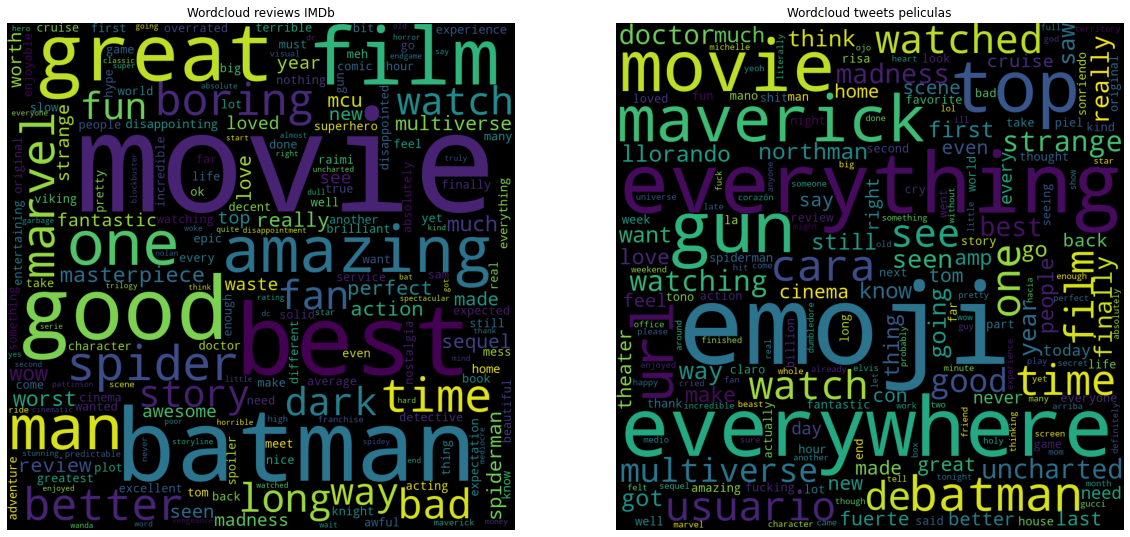

In [ ]:
from wordcloud import WordCloud

#para plotear las palabras en un wordcloud,es necesario que todas esten en una
#string larga.
#Junto todas las reviews en una string sola:
all_reviews_str = " ".join([review for review in df_rev_lemma["titulos"]])
#instancio el objeto wordcloud
wordcloud_rev = WordCloud(width = 1000, height = 1000, random_state=1,
                          collocations=False, stopwords=None).generate(all_reviews_str)

#hago lo mismo con los titulares no clickbait para plotearlos como wordcloud:
all_tweets_str = " ".join([tweet for tweet in df_tws_lemma["full_text"]])
wordcloud_tw = WordCloud(width = 1000, height = 1000, random_state=1,
                     collocations=False, stopwords=None).generate(all_tweets_str)
#ploteo las wordclouds
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
ax[0].set_title("Wordcloud reviews IMDb")
ax[0].imshow(wordcloud_rev)
ax[1].set_title("Wordcloud tweets peliculas")
ax[1].imshow(wordcloud_tw)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

#3ra Parte: Creación del modelo Multinomial Naive Bayes binario Stratified KFold
Vamos a crear un modelo para predecir la opinión de un usuario dada una review. Para hacer esto, optamos por Naive Bayes, que nos permite clasificar texto en base a las probabilidades que tienen las palabras que éste contiene de pertenecer a una clase o la otra, siguiendo la hipótesis de bag of words (bolsa de palabras, sin importar el orden en la oración).

Por otro lado, hacer Naive Bayes multinomial nos permite ajustar el hiperparámetro alpha, que es una medida de la cuenta inicial que tienen todas las palabras en el dataset, para evitar el hecho de que alguna palabra tenga probabilidad 0 de aparecer, y al multiplicar por el resto de las probabilidades, toda la cuenta se haga 0.

A su vez, optamos por el Stratified KFolding para separar el dataset en training y test, ya que es un metodo en donde la separación de la data en folds no se hace de forma ciega, sino que se distribuyen uniformemente para que no queden datasets desbalanceados a la hora de entrenar y testear.

Para hacer Naive Bayes, necesitamos la matriz de frecuencia, que es la matriz que cuenta la cantidad de apariciones de palabras (de entre todas las palabras del dataset, tambien llamado el vocabulario) en cada review.
Necesitamos tambien una forma de asociar esas palabras a la categoria de reviews positivas o reviews negativas. Para eso guardamos las opinion de cada pelicula como los labels con los cuales luego podremos indicar que esas palabras son correspondientes a tal o cual rating.

Como sólo tenemos puntajes para las reviews en IMDb, sólo usamos dicha base de datos para entrenar y testear el modelo:

In [ ]:
#inicializamos count vectorizer sin stop words porque ya las quitamos
vectorizer = CountVectorizer(stop_words=None)
#Entrenamos al vectorizer. Este objeto ordenara alfabeticamente las palabras y
#les pondra un indice segun corresponda a que documento. Luego contara la cantidad
#de apariciones que esa palabra tiene en el documento en cuestion.
#Para entrenarlo, vamos a pasarle todos los documentos, todas las reviews
vectorizer.fit(df_rev_lemma["titulos"])
#transformo las reviews en un objeto con la cuenta de las palabras que aparecen
#en cada review
allX = vectorizer.transform(df_rev_lemma["titulos"])
#los labels van a ser las opiniones de los usarios de IMDb. Transformo a vector
#de numpy para usar luego con sklearn
labels = df_rev_lemma["opinion"].to_numpy()

Separamos el dataset en training y hold out set:

In [ ]:
from sklearn.model_selection import train_test_split
X, X_final, y, y_final = train_test_split(allX, labels, test_size=0.25)

Para elegir el mejor hiperparametro que ajusta nuestra data, hacemos validacion cruzada con k folds de n = 5:

In [ ]:
#importamos el modelo
from sklearn.model_selection import StratifiedKFold
#pedimos 5 folds y creacion de los subconjuntos de forma aleatoria
skf = StratifiedKFold(n_splits=5, shuffle=True)
#arma los folds a partir de los datos
skf.get_n_splits(allX, labels)

5

Prodecemos a evaluar el modelo para varios alfas, y guardamos los resultados de la performance de cada modelo en una lista para despues plotearla

In [ ]:
auc_values = []
alpha_values = np.arange(0.1, 1.1, 0.1)
for alpha in alpha_values:
    #inicializo el modelo con este alpha
    mNB_aux = MultinomialNB(alpha=alpha)
    auc_temp = []
    for train_index, test_index in skf.split(X, y):
        #arma que es dato de entrenamiento y qué es dato de evaluación
        X_train, X_test = allX[train_index], allX[test_index]
        #idem con los targets
        y_train, y_test = labels[train_index], labels[test_index]
        #entreno
        mNB_aux.fit(X_train, y_train)
        #estimo probabilidades de que las cosas del test sean o no clickbait
        probas = mNB_aux.predict_proba(X_test)
        #calculo el AUC score, para ver que tan acertado estuve
        auc_score = roc_auc_score(y_test, probas[:,1])
        auc_temp.append(auc_score)
        #guardo el auc de este fold en la lista de aucs para este alpha
    #promedio el auc de todos los folds con este alpha, y lo guardo en la lista
    #de valores auc
    auc_values.append(np.mean(auc_temp))
    print(f"alpha : {alpha} - score : {np.mean(auc_temp)}")

alpha : 0.1 - score : 0.8442794996343329
alpha : 0.2 - score : 0.8507704711228739
alpha : 0.30000000000000004 - score : 0.8536924451619612
alpha : 0.4 - score : 0.8532663359126852
alpha : 0.5 - score : 0.855507531206358
alpha : 0.6 - score : 0.8560678197546043
alpha : 0.7000000000000001 - score : 0.8567401852449639
alpha : 0.8 - score : 0.857403635522398
alpha : 0.9 - score : 0.8559745557622659
alpha : 1.0 - score : 0.8571220999807379


Ploteamos la curva ROC para un modelo con el alpha que nos dio el mayor valor de AUC:

0.7000000000000001
0.8229634730624594
0.7456087624017339
Accuracy en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: 0.8670863401402323
Accuracy balanceado en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: 0.8229634730624594
Accuracy en conjunto de testeo Naive Bayes multinomial stratified KFold: 0.8028558268079227
Accuracy balanceado en conjunto de testeo Naive Bayes multinomial stratified KFold: 0.7456087624017339
AUC Score: 0.8581632714647458


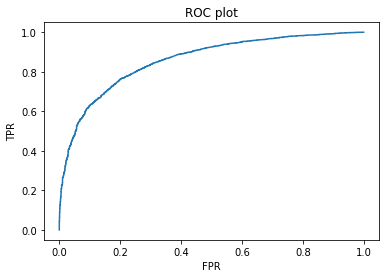

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score

alpha = alpha_values[auc_values.index(max(auc_values))]
print(alpha)
mNB = MultinomialNB(alpha=alpha)
#entrenamos el modelo
mNB.fit(X, y)
#score del modelo en el conjunto de entrenamiento
score_in_train = mNB.score(X, y)
predictions_train = mNB.predict(X)
balanced_acc_train = balanced_accuracy_score(y, predictions_train)
print(balanced_acc_train)
#score del modelo en el conjunto de testeo
score_in_test = mNB.score(X_final, y_final)
predictions_test = mNB.predict(X_final)
balanced_acc_test = balanced_accuracy_score(y_final, predictions_test)
print(balanced_acc_test)
#score_in_test_balanceado = balanced_accuracy_score(X_final, y_final)
print(f"Accuracy en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: {score_in_train}")
print(f"Accuracy balanceado en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: {balanced_acc_train}")
print(f"Accuracy en conjunto de testeo Naive Bayes multinomial stratified KFold: {score_in_test}")
print(f"Accuracy balanceado en conjunto de testeo Naive Bayes multinomial stratified KFold: {balanced_acc_test}")
probas = mNB.predict_proba(X_final)
auc_score = roc_auc_score(y_final, probas[:,1])
print(f"AUC Score: {auc_score}")
fpr, tpr, thresholds = roc_curve(y_final, probas[:,1]) # para plotear curva ROC con datos de entrenamiento
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC plot')
plt.plot(fpr,tpr)

Podemos hacer el mismo procedimiento pero usando el dataset de las reviews CON stopwords:

In [ ]:
#inicializamos count vectorizer. Si bien ahora si tenemos stop words, queremos
#considerarlas, por lo que inicializamos con stop_words=None para que no las saque
vectorizer_sw = CountVectorizer(stop_words=None)
#Entrenamos al vectorizer. 
vectorizer_sw.fit(df_rev_lemma_sw["titulos"])
#transformo las reviews en un objeto con la cuenta de las palabras que aparecen
#en cada review
allX_sw = vectorizer_sw.transform(df_rev_lemma_sw["titulos"])
#los labels van a ser las opiniones de los usarios de IMDb. Transformo a vector
#de numpy para usar luego con sklearn
labels_sw = df_rev_lemma_sw["opinion"].to_numpy()

Separamos el dataset en training y hold out set:

In [ ]:
from sklearn.model_selection import train_test_split
X_sw, X_sw_final, y_sw, y_sw_final = train_test_split(allX_sw, labels_sw, test_size=0.25)

Prodecemos a evaluar el modelo para varios alfas, y guardamos los resultados de la performance de cada modelo en una lista para despues plotearla

In [ ]:
auc_values = []
alpha_values = np.arange(0.1, 1.1, 0.1)
for alpha in alpha_values:
    #inicializo el modelo con este alpha
    mNB_sw_aux = MultinomialNB(alpha=alpha)
    auc_temp = []
    for train_index, test_index in skf.split(X_sw, y_sw):
        #arma que es dato de entrenamiento y qué es dato de evaluación
        X_train, X_test = allX_sw[train_index], allX_sw[test_index]
        #idem con los targets
        y_train, y_test = labels_sw[train_index], labels_sw[test_index]
        #entreno
        mNB_sw_aux.fit(X_train, y_train)
        #estimo probabilidades de que las cosas del test sean o no clickbait
        probas = mNB_sw_aux.predict_proba(X_test)
        #calculo el AUC score, para ver que tan acertado estuve
        auc_score = roc_auc_score(y_test, probas[:,1])
        auc_temp.append(auc_score)
        #guardo el auc de este fold en la lista de aucs para este alpha
    #promedio el auc de todos los folds con este alpha, y lo guardo en la lista
    #de valores auc
    auc_values.append(np.mean(auc_temp))
    print(f"alpha : {alpha} - score : {np.mean(auc_temp)}")

alpha : 0.1 - score : 0.8481050786094164
alpha : 0.2 - score : 0.852191960839798
alpha : 0.30000000000000004 - score : 0.8567171441203583
alpha : 0.4 - score : 0.8575580219734447
alpha : 0.5 - score : 0.8577327415357605
alpha : 0.6 - score : 0.8575445480802422
alpha : 0.7000000000000001 - score : 0.8602031988714348
alpha : 0.8 - score : 0.8587848794430576
alpha : 0.9 - score : 0.8584356939946931
alpha : 1.0 - score : 0.8577930552111626


Ploteamos la curva ROC para un modelo con el alpha que nos dio el mayor valor de AUC:

0.7000000000000001
Accuracy en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: 0.8683658324376887
Accuracy balanceado en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: 0.8291339741438493
Accuracy en conjunto de testeo Naive Bayes multinomial stratified KFold: 0.8113004759711346
Accuracy balanceado en conjunto de testeo Naive Bayes multinomial stratified KFold: 0.7579324357995958
AUC Score: 0.8642120806149025


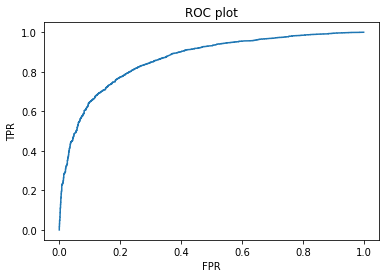

In [ ]:
from sklearn.metrics import balanced_accuracy_score

alpha = alpha_values[auc_values.index(max(auc_values))]
print(alpha)
mNB_sw = MultinomialNB(alpha=alpha)
#entrenamos el modelo
mNB_sw.fit(X_sw, y_sw)
#score del modelo en el conjunto de entrenamiento
score_in_train = mNB_sw.score(X_sw, y_sw)
predictions_sw_train = mNB_sw.predict(X_sw)
balanced_acc_sw_train = balanced_accuracy_score(y_sw, predictions_sw_train)
#score del modelo en el conjunto de testeo
score_in_test = mNB_sw.score(X_sw_final, y_sw_final)
predictions_sw_test = mNB_sw.predict(X_sw_final)
balanced_acc_sw_test = balanced_accuracy_score(y_sw_final, predictions_sw_test)
print(f"Accuracy en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: {score_in_train}")
print(f"Accuracy balanceado en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: {balanced_acc_sw_train}")
print(f"Accuracy en conjunto de testeo Naive Bayes multinomial stratified KFold: {score_in_test}")
print(f"Accuracy balanceado en conjunto de testeo Naive Bayes multinomial stratified KFold: {balanced_acc_sw_test}")
probas_sw = mNB_sw.predict_proba(X_sw_final)
auc_score_sw = roc_auc_score(y_sw_final, probas_sw[:,1])
print(f"AUC Score: {auc_score_sw}")
fpr, tpr, thresholds = roc_curve(y_sw_final, probas_sw[:,1]) # para plotear curva ROC con datos de entrenamiento
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC plot')
plt.plot(fpr,tpr)

Vemos que los resultados son muy silimares, tanto en el dataset sin stopwords como en el que si las tiene.

Veamos ahora como este modelo es capaz de predecir las opiniones de tweets, y que tanto se parecen las opiniones de los usuarios de Twitter a las de IMDb:

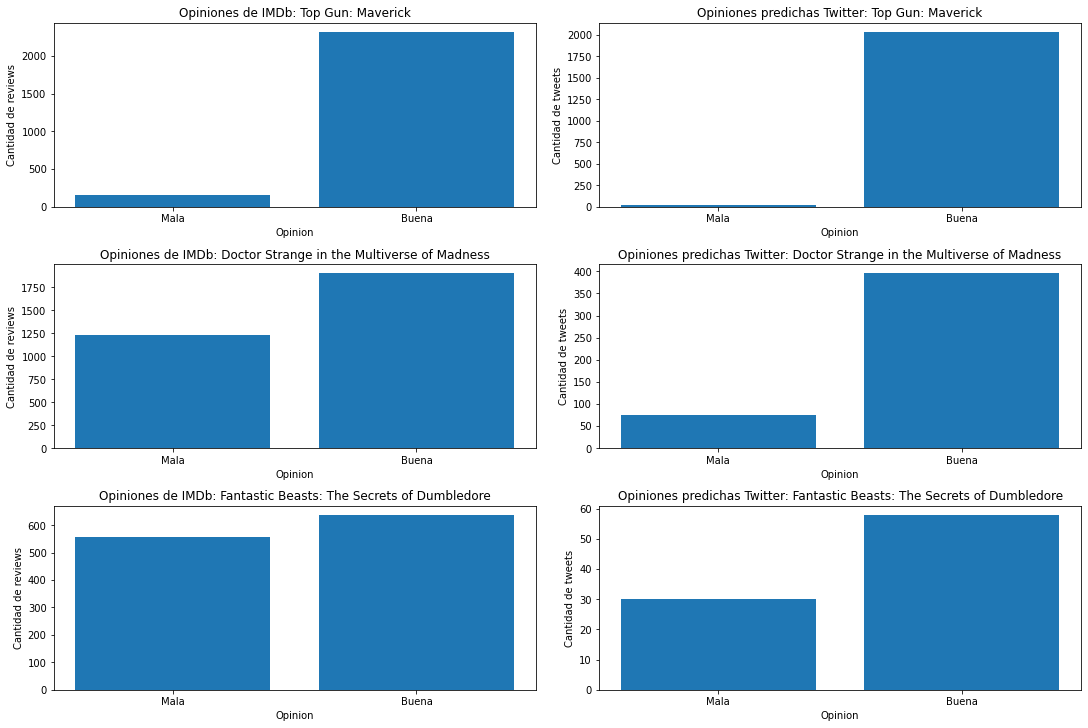

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), constrained_layout=True)
for i, j in enumerate([0, 1, 3]):
  opiniones_peli = dfs_reviews[j]["puntajes"].apply(lambda x: x > 5)
  allX_twt = vectorizer.transform(dfs_tw[j]["full_text"])
  pred_twt = pd.DataFrame(mNB.predict(allX_twt))
  ax[i][0].set_title(f"Opiniones de IMDb: {titulos_pelis[j]}")
  ax[i][0].set_xlabel("Opinion")
  ax[i][0].set_ylabel("Cantidad de reviews")
  ax[i][0].bar(["Mala", "Buena"], opiniones_peli.value_counts().sort_values())
  ax[i][1].set_title(f"Opiniones predichas Twitter: {titulos_pelis[j]}")
  ax[i][1].set_xlabel("Opinion")
  ax[i][1].set_ylabel("Cantidad de tweets")
  ax[i][1].bar(["Mala", "Buena"], pred_twt.value_counts().sort_values())

plt.show()

Vemos que hay una gran similitud entre las opiniones de los usuarios de IMDb y los de Twitter.

#4ta parte: Predicción de la opinión de un tweet y validación con análisis de sentimiento
Ahora utilizaremos el modelo que entrenamos en el dataset de IMDb para predecir la opinión positiva o negativa de una "review" de Twitter, es decir, de un tweet que opina sobre una pelicula.

Para ello es necesario transformar el database de tweets en la matriz de frecuencia de las palabras que usaron los usuarios de IMDb para calificar las peliculas, pero esta vez contanto la cantidad de veces que dichas palabras aparecen un tweet dado.

In [ ]:
#Transformo a los tweets en el objeto que tiene la matriz de frecuencia de las 
#palabras utilizadas en los tweets que fueron usadas tambien por los usuarios
#de IMDb
xTW = vectorizer.transform(df_tws_lemma["full_text"])
#evaluo la prediccion del modelo Naive Bayes Multinomial entreando sin stopwords
yTW = mNB.predict(xTW)
print(yTW)

[ True  True  True ...  True  True  True]


Hago lo propio con el modelo entrenado con stopwords

In [ ]:
#Transformo a los tweets en el objeto que tiene la matriz de frecuencia de las 
#palabras utilizadas en los tweets que fueron usadas tambien por los usuarios
#de IMDb
xTW_sw = vectorizer_sw.transform(df_tws_lemma_sw["full_text"])
#evaluo la prediccion del modelo Naive Bayes Multinomial entreando sin stopwords
yTW_sw = mNB_sw.predict(xTW_sw)
print(yTW_sw)

[ True  True  True ...  True  True  True]


Como no tenemos forma de ver si las predicciones de nuestro modelo son acertadas (pues no existe la opcion de rankear peliculas en twitter), utilizaremos un modelo de análisis de sentimiento como validación. La idea es que si el tweet es clasificado como opinión positiva, debería tener sentimientos positivos asociados a él, y viceversa si la opinion sobre la película fue negativa.

In [ ]:
analyzer = create_analyzer('emotion', lang = 'en')


Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/999 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

Como tenemos demasiados tweets para analizar el sentimiento, vamos a utilizar solo
una pequeña parte para ver como se desempeó nuestro modelo, pues el analisis
de sentimiento de una frase conlleva mucho tiempo computacional

In [ ]:
sentimientos = ['others', 'joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']
print("Cantidad de tweets total: ", len(df_tws_lemma))
#seleccionamos los primeros tweets para el analisis de sentimiento
cant_tweets_test = 10
print("Cantidad de tweets utilizados para el test: ", cant_tweets_test)
df_tws_test = df_tws_lemma[:cant_tweets_test]
probas = [analyzer.predict(tweet).probas.values() for tweet in df_tws_test["full_text"]]
#el dataframe de sentimientos para estos tweets es
df_sentim_test = pd.DataFrame(probas, columns=sentimientos)
#print(df_sentim_test)
#por otro lado, lo que predijo el modelo para estos tweets fue
#(lo convertimos en dataframe y le ponemos titulo a la columna para concatenarlo luego)
y_test = pd.DataFrame(yTW[:cant_tweets_test], columns=["opinion_pred"])
#print(y_test)
#puedo unir todo en el mismo dataframe
df_test = pd.concat([df_tws_test, y_test, df_sentim_test], axis=1)
print(df_test)

Cantidad de tweets total:  7950
Cantidad de tweets utilizados para el test:  10
                                           full_text  opinion_pred    others  \
0  watched top gun maverick kind went like think ...          True  0.938832   
1  love top gun cannot wait see top gun maverick ...          True  0.873528   
2  top gun maverick definitely improvement predec...          True  0.817235   
3  boarded plane future perfect blasting ear cuz ...          True  0.966943   
4  know become spent morning reading top gun mave...          True  0.956350   
5  watched top gun maverick wife last night worth...          True  0.039835   
6  sweetie went movie first time since american g...          True  0.048012   
7  lezgooo top gun maverick still showing nearest...          True  0.956985   
8  genuinely cannot understand people willingly w...          True  0.026731   
9  went see top gun maverick last night see mile ...          True  0.016630   

        joy   sadness     anger  surpri

Deberia ocurrir que para las reviews clasificadas como positivas, el analisis de sentimiento refleje tambien la naturaleza positiva del comentario, teniendo scores del tipo "joy" o "surprise" relativamente alto en comparacion con sentimientos como "sadness" o "anger", y a la inversa cuando son reviews negativas.

Cuando el análisis de sentimiento indica "other" (es decir, otro sentimiento que no es los comúnes), podemos utilizar el segundo score mas alto en el analisis para corroborar si fue positivo o negativo.

In [ ]:
#no vamos a considerar la columna "other" en este analisis
columnas = ['joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']
#creamos un dataframe que contenga la emocion preponderante en cada tweet
df_maximos = df_test[columnas].idxmax(axis=1).rename("sentimiento_max")
#unimos el dataframe del sentimiento maximo con el de la opinion predicha por nuestro modelo
df_test_sentMax = y_test.join(df_maximos)
print(df_test_sentMax)

   opinion_pred sentimiento_max
0          True             joy
1          True             joy
2          True             joy
3          True             joy
4          True             joy
5          True             joy
6          True             joy
7          True             joy
8          True         disgust
9          True             joy


Vemos que se condice bastante bien la predicción del modelo con el sentimiento que evoca el tweet en el analizador de sentimientos. 
Cuantifiquemos estas observaciones, viendo que tanto se condice una opinion positiva con un sentimiento positivo, y una opinion negativa con un sentimiento negativo

In [ ]:
sentimientos_positivos = ["joy", "surprise"]
sentimientos_negativos = ["disgust", "sadness", "anger", "fear"]
#creo un dataframe con los tweets que fueron bien clasificados, es decir, que dado que predijimos True (opinion POSITIVA),
#el analizador de sentimiento indico que predominaba un sentimiento POSITIVO, y, dado que predijimos False (opinion NEGATIVA),
#el analizador de sentimiento indico que predominaba un sentimiento NEGATIVO:
df_correctos = df_test_sentMax[((df_test_sentMax["opinion_pred"]==True) & (df_test_sentMax["sentimiento_max"].isin(sentimientos_positivos))) | ((df_test_sentMax["opinion_pred"]==False) & (df_test_sentMax["sentimiento_max"].isin(sentimientos_negativos)))]
print("La cantidad de tweets bien clasificados es de: ", len(df_correctos))
print("La cantidad de tweets mal clasificados es de: ", len(df_test_sentMax) - len(df_correctos))
print("Porcentaje de tweets bien clasificados: ", len(df_correctos)/len(df_test_sentMax))
print("Porcentaje de tweets mal clasificados: ", (len(df_test_sentMax) - len(df_correctos))/len(df_test_sentMax))

La cantidad de tweets bien clasificados es de:  9
La cantidad de tweets mal clasificados es de:  1
Porcentaje de tweets bien clasificados:  0.9
Porcentaje de tweets mal clasificados:  0.1


#5ta parte: Predicción de rating, análisis multiclase Naive Bayes
En esta sección vamos a predecir ratings dado una review. Sólo vamos a trabajar con el dataset de IMDb, pues es el que nos va a permitir entrenar y testear el modelo con los ratings.

Nuevamente vamos a trabajr con Multinomial Naive Bayes, solo que esta vez para el caso multiclase, pues la idea sera predecir la cantidad de estrellas dadas por el usuario a la película en base a la review. Utilizaremos el siguiente criterio: 
Si bien la cantidad de clases originales es 10 (pues los usuarios pueden 
rankear de 1 a 10 estrellas), vamos a reducir la cantidad de clases a 5, asociando la cantidad de estrellas de a pares: Si el usuario indicó 9 estrellas o 10 estrellas, esto se mapea a la clase 5 estrellas. Esto con el objetivo de reducir la cantidad de clases y asi mejorar la capacidad de predicción del modelo.

Aplicamos el criterio para crear una nueva feature con la canidad de estrellas reducidas en base al ranking dado por el usuario de IMDb:

In [ ]:
#creo una copia del dataset con reviews lematizadas y sin stop words
df_multiClase = df_rev_lemma.copy()
#creo una nueva columna con el ranking reducido acordemente
df_multiClase['sobreCinco'] = (df_multiClase['puntajes']+1) // 2
print(df_multiClase)

                                   titulos  puntajes  opinion  sobreCinco
0            truly epic blockbuster needed        10     True           5
1    slightly different review please stay        10     True           5
2                          best sequel yet        10     True           5
3                                 go movie        10     True           5
4                   real cinema experience        10     True           5
..                                     ...       ...      ...         ...
851  decent movie ruined lady gagas acting         5    False           3
852                         good excellent         5    False           3
853                                opinion         8     True           4
854                             delightful        10     True           5
855                            story gucci         4    False           2

[26052 rows x 4 columns]


Como vamos a trabajar con el mismo dataset que en la parte 4, solo usamos la variables allX, que contiene a las reviews transformadas en matriz de frecuencia, y creamos un nuevo label para las reviews:

In [ ]:
#los labels van a ser las estrellas reducidas segun el rating del usuario
labels_rating = df_multiClase["sobreCinco"].to_numpy()
print(labels_rating)

[5 5 5 ... 4 5 2]


Separamos el dataset en training y hold out set:

In [ ]:
from sklearn.model_selection import train_test_split
X_rating, X_rating_final, y_rating, y_rating_final = train_test_split(allX, labels_rating, test_size=0.25)

Prodecemos a evaluar el modelo para varios alfas, y guardamos los resultados de la performance de cada modelo en una lista para despues plotearla

In [ ]:
auc_values = []
alpha_values = np.arange(0.1, 1.1, 0.1)
for alpha in alpha_values:
    #inicializo el modelo con este alpha
    mNB_rt_aux = MultinomialNB(alpha=alpha)
    auc_temp = []
    for train_index, test_index in skf.split(X_rating, y_rating):
        #arma que es dato de entrenamiento y qué es dato de evaluación
        X_train, X_test = allX[train_index], allX[test_index]
        #idem con los targets
        y_train, y_test = labels_rating[train_index], labels_rating[test_index]
        #entreno
        mNB_rt_aux.fit(X_train, y_train)
        #estimo probabilidades de que las cosas del test sean o no clickbait
        probas = mNB_rt_aux.predict_proba(X_test)
        #calculo el AUC score, para ver que tan acertado estuve
        auc_score = roc_auc_score(y_test, probas, multi_class="ovr")
        auc_temp.append(auc_score)
        #guardo el auc de este fold en la lista de aucs para este alpha
    #promedio el auc de todos los folds con este alpha, y lo guardo en la lista
    #de valores auc
    auc_values.append(np.mean(auc_temp))
    print(f"alpha : {alpha} - score : {np.mean(auc_temp)}")

alpha : 0.1 - score : 0.7550712006664503
alpha : 0.2 - score : 0.7606789338431537
alpha : 0.30000000000000004 - score : 0.764901737473955
alpha : 0.4 - score : 0.7687992721237076
alpha : 0.5 - score : 0.769852985125847
alpha : 0.6 - score : 0.770327634861693
alpha : 0.7000000000000001 - score : 0.7717660335875938
alpha : 0.8 - score : 0.7701872062011571
alpha : 0.9 - score : 0.7706752410316563
alpha : 1.0 - score : 0.7721315679517003


Ploteamos la curva ROC para un modelo con el alpha que nos dio el mayor valor de AUC:

In [ ]:
from sklearn.metrics import balanced_accuracy_score

alpha = alpha_values[auc_values.index(max(auc_values))]
print(alpha)
mNB_rating = MultinomialNB(alpha=alpha)
#entrenamos el modelo
mNB_rating.fit(X_rating, y_rating)
#score del modelo en el conjunto de entrenamiento
score_in_train = mNB_rating.score(X_rating, y_rating)
predictions_rt_train = mNB_rating.predict(X_rating)
balanced_acc_rt_train = balanced_accuracy_score(y_rating, predictions_rt_train)
#score del modelo en el conjunto de testeo
score_in_test = mNB_rating.score(X_rating_final, y_rating_final)
predictions_rt_test = mNB_rating.predict(X_rating_final)
balanced_acc_rt_test = balanced_accuracy_score(y_rating_final, predictions_rt_test)
print(f"Accuracy en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: {score_in_train}")
print(f"Accuracy balanceado en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: {balanced_acc_rt_train}")
print(f"Accuracy en conjunto de testeo Naive Bayes multinomial stratified KFold: {score_in_test}")
print(f"Accuracy balanceado en conjunto de testeo Naive Bayes multinomial stratified KFold: {balanced_acc_rt_test}")
probas_rt = mNB_rating.predict_proba(X_rating_final)
auc_score_rt = roc_auc_score(y_rating_final, probas_rt, multi_class="ovr")
print(f"AUC Score: {auc_score_rt}")

0.7000000000000001
Accuracy en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: 0.680382824095399
Accuracy balanceado en conjunto de entrenamiento Naive Bayes multinomial stratified KFold: 0.5754157677234562
Accuracy en conjunto de testeo Naive Bayes multinomial stratified KFold: 0.5418393981268232
Accuracy balanceado en conjunto de testeo Naive Bayes multinomial stratified KFold: 0.41078333970417047
AUC Score: 0.7784480744843097


Podemos ver la distribución de ratings del hold out dataset y compararla con la distribución de ratings real de todo el dataset:

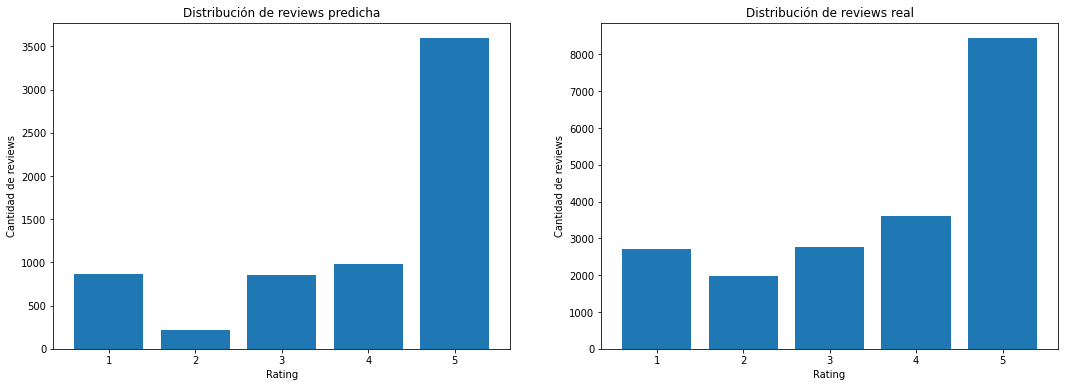

In [ ]:
pred = mNB_rating.predict(X_rating_final)

#cuento la cantidad de ratings predichos para el hold out dataset
ar_unique, i, c = np.unique(pred, return_counts=True, return_index=True)
#cuento la cantidad de scores reales para todo el dataset
ar_unique, i, c1 = np.unique(y_rating, return_counts=True, return_index=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].bar(['1','2','3','4','5'], c)
ax[0].set_title("Distribución de reviews predicha")
ax[0].set_ylabel("Cantidad de reviews")
ax[0].set_xlabel("Rating")
ax[1].bar(['1','2','3','4','5'], c1)
ax[1].set_title("Distribución de reviews real")
ax[1].set_ylabel("Cantidad de reviews")
ax[1].set_xlabel("Rating")
plt.show()

Vemos que la distribucion de ratings es bastante similar entre lo predicho y lo real, lo que nos da confianza sobre nuestro modelo.

Ahora veamos que tanto se parece la distribucion de ratings dada a cada pelicula por los usuarios de IMDb, y la distribución de ratings predicha por nuestro modelo para los tweets referentes a esa pelicula:

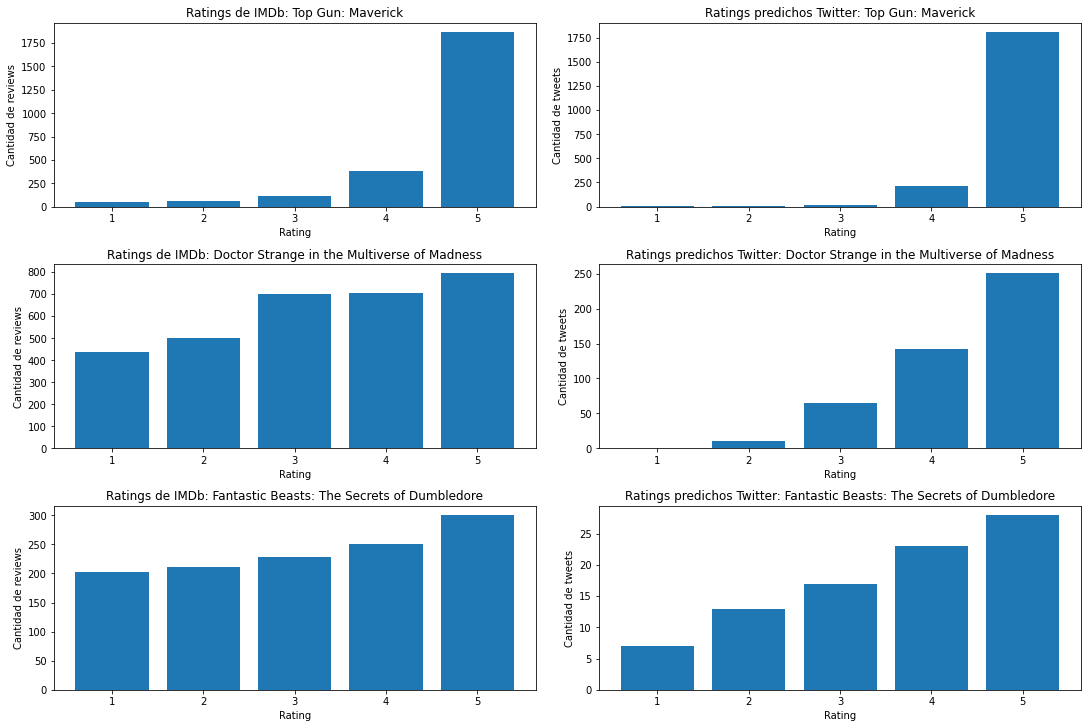

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), constrained_layout=True)
#fig.tight_layout()
for i, j in enumerate([0, 1, 3]):
  ratings_peli = dfs_reviews[j]["puntajes"].apply(lambda x: (x+1)//2)
  allX_twt = vectorizer.transform(dfs_tw[j]["full_text"])
  pred_twt = pd.DataFrame(mNB_rating.predict(allX_twt))
  ax[i][0].set_title(f"Ratings de IMDb: {titulos_pelis[j]}")
  ax[i][0].set_xlabel("Rating")
  ax[i][0].set_ylabel("Cantidad de reviews")
  ax[i][0].bar(range(1, 6), ratings_peli.value_counts().sort_values())
  ax[i][1].set_title(f"Ratings predichos Twitter: {titulos_pelis[j]}")
  ax[i][1].set_xlabel("Rating")
  ax[i][1].set_ylabel("Cantidad de tweets")
  ax[i][1].bar(range(1, 6), pred_twt.value_counts().sort_values())

plt.show()

Nuevamente vemos que las opiniones de los usuarios de IMDb y los de Twitter se parecen: las distribuciones de ratings son muy similares para las películas analizadas.